In [1]:
# Libraries 
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# So the notebook doesn't yell at me
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Zillow .py stuff and functions
from acquire import get_zillow
from prepare import clean_zillow_dataset, get_zillow

#Some stuff I might have forgotten
import env
from env import user, password, host
from scipy import stats



# sklearn modeling stuff
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE, SequentialFeatureSelector
from sklearn.model_selection import train_test_split
#from evaluate import select_kbest_feature_engineering, rfe_feature_engineering
#from evaluate import scaled_data, assessed_value_regression_plot, baseline_vs_model_regression
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split

from math import sqrt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

### Acquisition

In [2]:
# Lets get the data
df = get_zillow()
df = clean_zillow_dataset(df)
df.head()

,bedroom_count,bath_count,finished_sq_feet,year_built,fips,home_value
0,2,1.0,1412.0,1947,6037,222671.0
1,3,2.0,1296.0,1955,6037,64968.0
2,3,1.0,1044.0,1947,6037,126800.0
3,3,2.0,1336.0,1955,6037,213833.0
4,3,2.0,1510.0,1979,6037,338022.0


In [3]:
#df.to_csv("/Users/luisarce/codeup-data-science/Regression_Project/regression_zillow.csv")

In [4]:
# Check shape of import
df.shape

(55735, 6)

### Preparation
- Just going to scrub for outliers as a lot of my cleaning can be found in my prepare.py file.

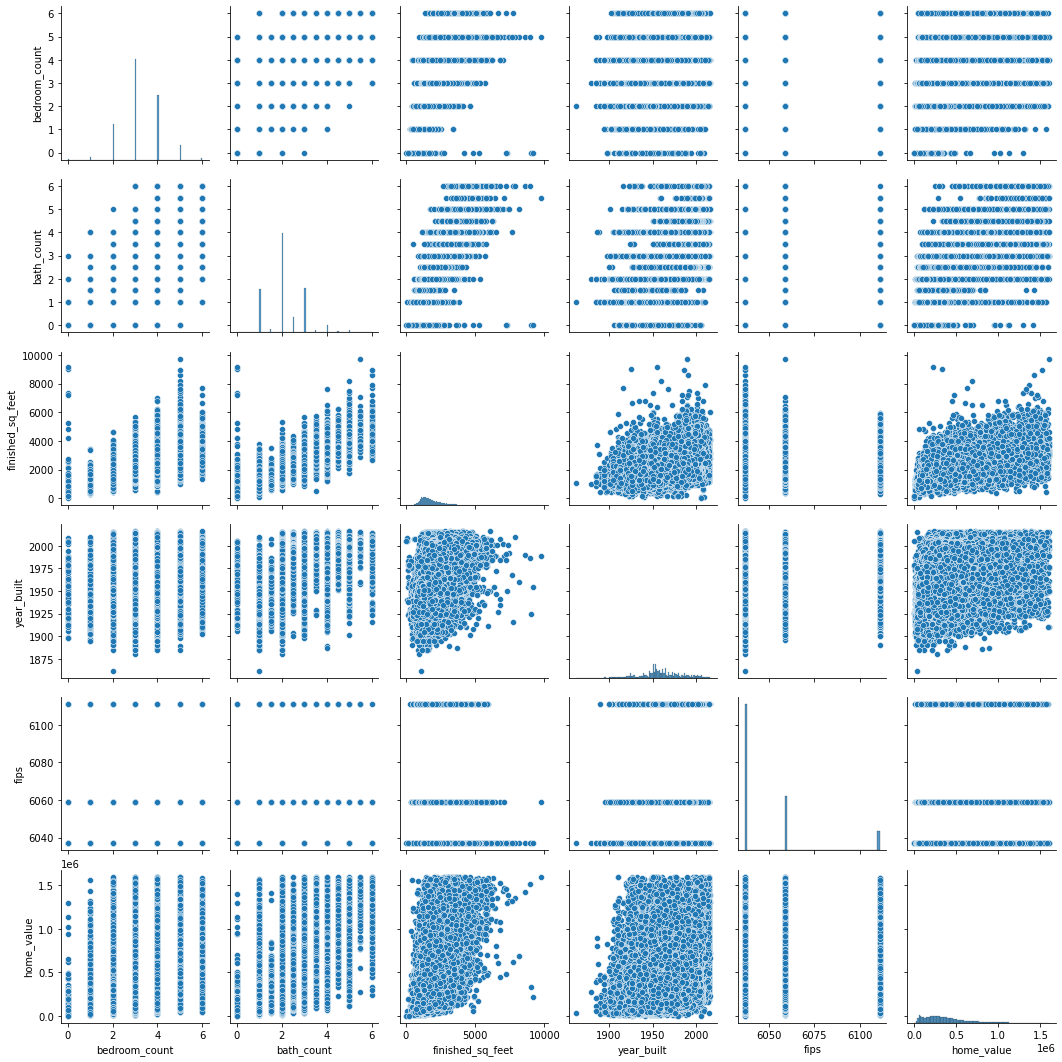

In [5]:
# cleaning for outliers
def zillow_outliers(df):
    df = df[df["bath_count"] <= 6]
    df = df[df["bedroom_count"] <= 6]
    df = df[df["finished_sq_feet"] <= 10000]
    df = df[df["home_value"] <= 1_600_000]

    return df
df = zillow_outliers(df)
df.shape # checks out!


# Choose reasonings for why i chose the values and show distribution. 

# Pairplot the numeric variables

sns.pairplot(df)
plt.show()

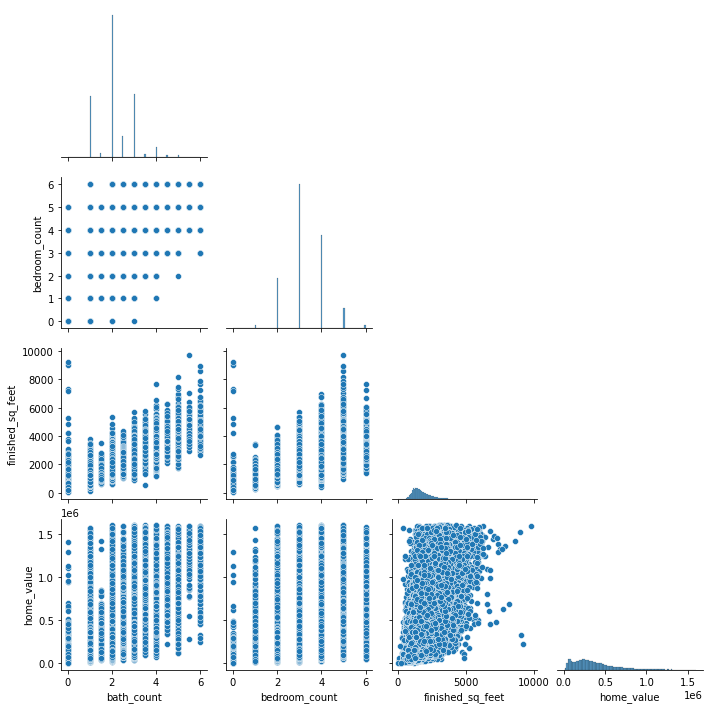

In [6]:
# We can drop the redundant information in the upper right half of the chart if we like.

sns.pairplot(df[['bath_count', 'bedroom_count', 'finished_sq_feet', 'home_value']], corner=True)
plt.show()

### Train, Validate and Test

- a df for TRAINING the algorithms
- a df for VALIDATING the models developed on unseen data
- a df for TESTING the best performing model to ensure the model is able to be generalized on a final set of unseen data.



In [7]:
# splitting the data into train, validate, and test
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
print(train.shape, validate.shape, test.shape)

(30266, 6) (12972, 6) (10810, 6)


In [8]:
# setting independent/dependent variables in ea. sub-dataset

X_train = train.drop(columns=["home_value"])
y_train = train.home_value

X_validate = validate.drop(columns=["home_value"])
y_validate = validate.home_value

X_test = test.drop(columns=["home_value"])
y_test = test.home_value

## Exploration


- Using the initial questions to guide the exploration.
- Create visualizations to explain the correlations.
- Perform some stats tests to infer key drivers through feature engineering.


#### Target Variable:
- home_value

* Dropped tax_amount because that is a strong predictor of home_value and may cause data leakage

##### Question 1: Does the size of a home impact its value?

Once can probably assume that square footage is connected to it's home value, but are we sure? We see in many cases in the city where you have a small home but the value of the home is still high. We're going to run a statistical test to determine if there is a strong correlation between these two variables.

Y = home_value
X = Finished_sq_feet

##### Question 2: Is the amount of bathrooms connected to a homes value?

While bathrooms don't take up much square footage, this report is trying to conclude if there is a connection between the amount of bathrooms a property has and its value.


### Does the size of a home impact its value?

Null Hypothesis: Finished_sq_feet is independent of home_value.

Alternate Hypothesis: Finished_sq_feet is correlated with home_value

Alpha =0.05

In [47]:
### Calculate the variances 
X_train.finished_sq_feet.var(), y_train.home_value.var()
print(X_train.finished_sq_feet.var())
print(y_train.var())

575856.3846868556
home_value                8.005974e+10
home_value_pred_mean      5.456296e-15
home_value_pred_median    0.000000e+00
home_value_pred_lm        2.788295e+10
home_value_pred_lars      2.779728e+10
home_value_pred_glm       3.151853e+10
dtype: float64


In [49]:


### Perform 2 sample t-test
t, p = stats.ttest_ind(X_train.finished_sq_feet,
                       y_train.home_value,
                       equal_var=False)
print(t, p / 2)

### Decide whether to reject or accept the null hypothesis

if p < 0.5:
    print('Reject Null Hypotheis')
else:
    print('Accept Null Hypotheis')

-236.1580472990187 0.0
Reject Null Hypotheis


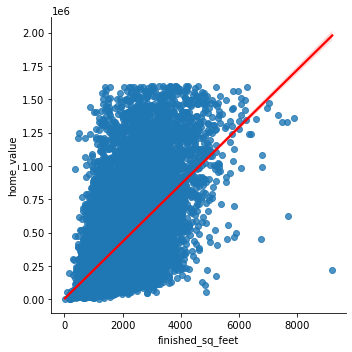

In [15]:
# Takeaways
# My lmplot chart shows me that there is a linear relationship between finished_sq_feet and home_value.

sns.lmplot(x="finished_sq_feet", y="home_value", data=train, line_kws={'color': 'red'})
plt.show()

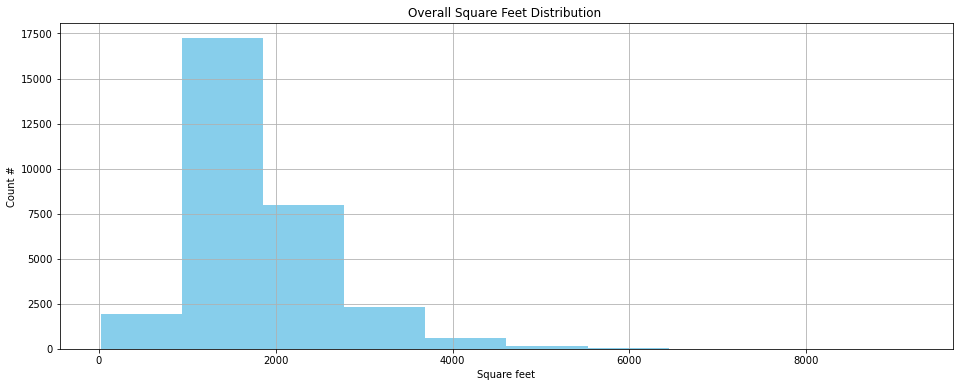

In [16]:
# Plot Square feet distribution
plt.figure(figsize = (16, 6))
plt.title('Overall Square Feet Distribution ')
plt.ylabel('Count #')
plt.xlabel('Square feet')
train.finished_sq_feet.hist(color = "skyblue", lw=0)
plt.show()

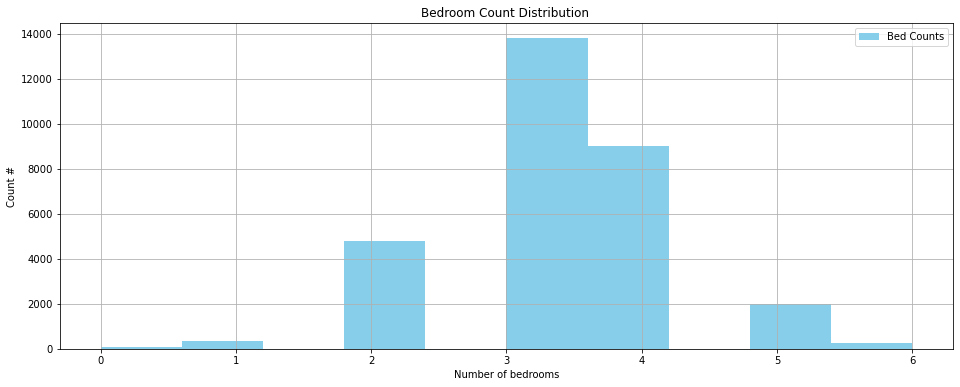

In [17]:
# Plot bedroom count distribution
plt.figure(figsize = (16, 6))
plt.title('Bedroom Count Distribution ')
plt.ylabel('Count #')
plt.xlabel('Number of bedrooms')
train.bedroom_count.hist(color = "skyblue", lw=0, label = 'Bed Counts')
plt.legend()
plt.show()

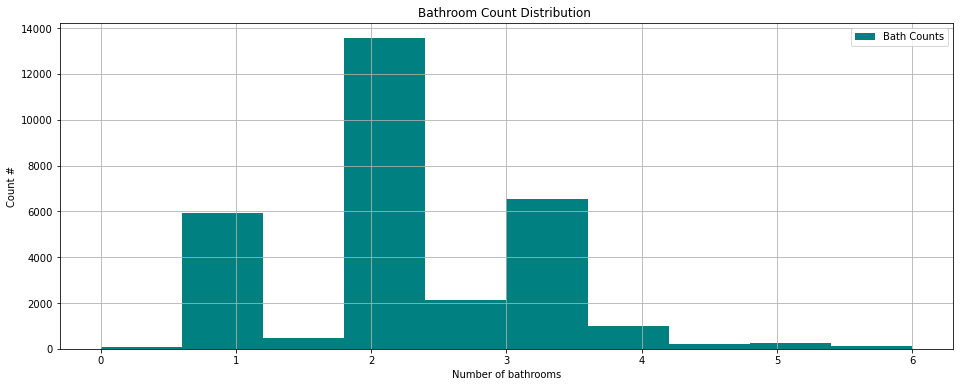

In [18]:
# Plot bathroom count distribution
plt.figure(figsize = (16, 6))
plt.title('Bathroom Count Distribution ')
plt.ylabel('Count #')
plt.xlabel('Number of bathrooms')
train.bath_count.hist(color = "teal", lw=0, label = 'Bath Counts')
plt.legend()
plt.show()

#### Takeaways
- 3 bedrooms and 2 bathrooms are the most common household classification in 2017

## Feature Engineering
### What features are key predictors of home value?

- SpearmanR
- Pearsons

### Whats our findings?
Bedroom count, bathroom count and home square feet correlate with home value

### Is the amount of bathrooms connected to a homes value?

Null Hypothesis: bath_count is independent of home_value.

Alternate Hypothesis: bath_count is correlated with home_value

Alpha =0.05

##### Pearson R Hypothesis

- Null Hypothesis: There isn't a linear correlation amongst the variables
- Alternative Hypothesis: There is a linear correlation amongst the variables

Alpha: 0.05

The smaller the P value, the more you should reject the null hypothesis.

In [54]:
# Calculate Pearson Correlation Coefficient for bathroom hypothesis

x = X_train.bath_count
y = y_train.home_value

corr, p = stats.pearsonr(x, y)
corr, p


(0.4958178413784224, 0.0)

In [66]:
### Decide whether to reject or accept the null hypothesis

if p < 0.05:
    print('Reject Null Hypothesis')
else:
    print('Accept Null Hypothesis')

Reject Null Hypothesis


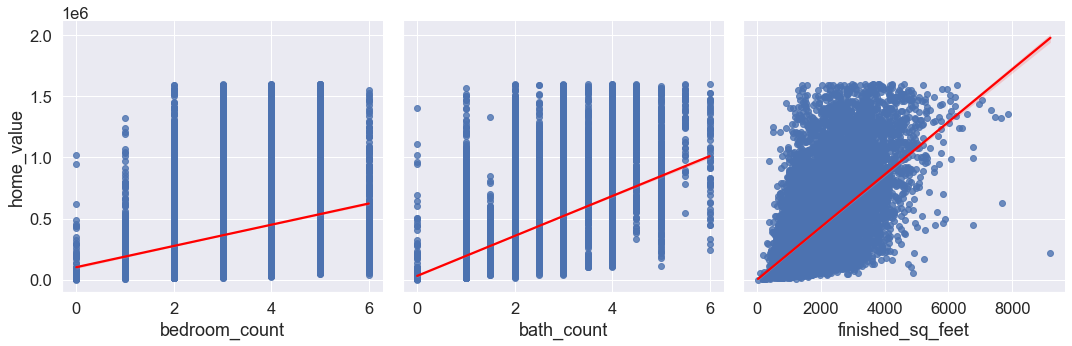

In [65]:
continous_with_continous = sns.pairplot(train, kind='reg', plot_kws={'line_kws':{'color':'red'}}, x_vars = ['bedroom_count', 'bath_count', 'finished_sq_feet'], 
                 y_vars = ['home_value'])

continous_with_continous.fig.set_size_inches(16,7)

In [55]:
# Conduct SpearmanR test

zillow_spearman = train.drop(columns=['year_built', 'fips']).corr(method='spearman')
zillow_spearman


,bedroom_count,bath_count,finished_sq_feet,home_value
bedroom_count,1.000000,0.619077,0.644233,0.275703
bath_count,0.619077,1.000000,0.814557,0.449422
finished_sq_feet,0.644233,0.814557,1.000000,0.496269
home_value,0.275703,0.449422,0.496269,1.000000


<AxesSubplot:>

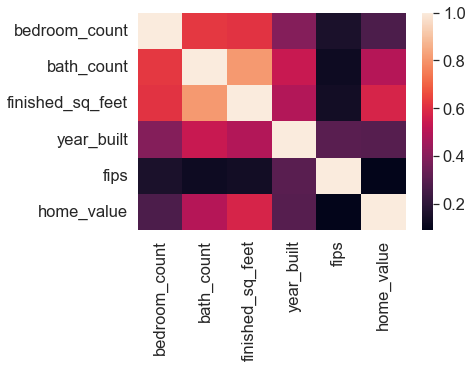

In [59]:
# Seaborn Heat map shows us the correlation coefficient for comparing continuous values against other continuous values
sns.heatmap(train.corr())

In [34]:
# let's generate an average baseline prediction

baseline_predictions = round(train["home_value"].mean(), 2)
baseline_predictions

385876.79

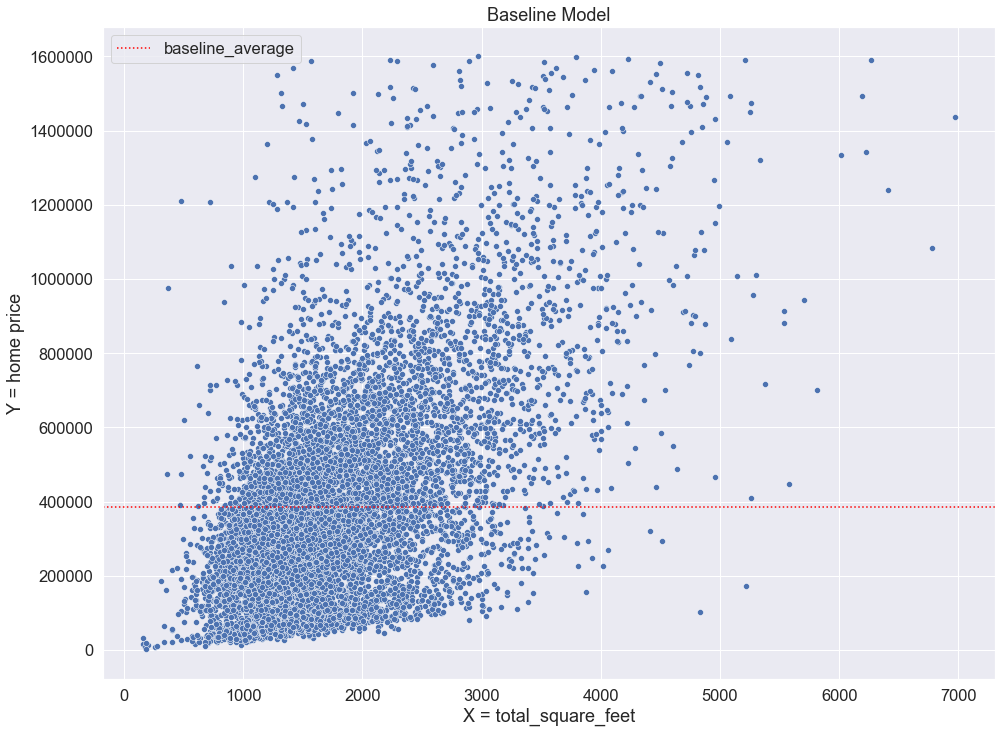

In [39]:
# Time to plot the mean baseline prediction against actual targets

plt.figure(figsize = (16,12))
sns.set(font_scale = 1.5)

sns.scatterplot(x = "finished_sq_feet", y = "home_value", data = train.sample(10000), x_jitter = 0.5)
plt.ticklabel_format(style = "plain") 

plt.axhline(baseline_predictions, ls = ':', color = "red", label = "baseline_average")
plt.xlabel('X = total_square_feet')
plt.ylabel('Y = home price')

plt.legend()
plt.title('Baseline Model')
plt.show()

In [67]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict home_value_pred_mean
home_value_pred_mean = y_train['home_value'].mean()
y_train['home_value_pred_mean'] = home_value_pred_mean
y_validate['home_value_pred_mean'] = home_value_pred_mean

# 2. compute home_value_pred_median
home_value_pred_median = y_train['home_value'].median()
y_train['home_value_pred_median'] = home_value_pred_median
y_validate['home_value_pred_median'] = home_value_pred_median

# 3. RMSE of home_value_pred_mean
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of home_value_pred_median
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))



## Put this next to baseline

RMSE using Mean
Train/In-Sample:  282943.63 
Validate/Out-of-Sample:  285912.23
RMSE using Median
Train/In-Sample:  290316.99 
Validate/Out-of-Sample:  293079.05


#### Takeaways
- Baseline prediction mean is the predicted house value average of all records in the Zillow train dataset
- Is this the correct average to assume for the dataset?

### Key Findings:
- Finished_sq_feet has a high correlation to home_value and is the key driver for the price of a home.
- Bathrooms and bedrooms appear to be connected to the home's value

### Modeling

#### Scale the data
- we want to visualize the combination of 2 variables with different scales.

Text(0.5, 1.0, 'Scaled')

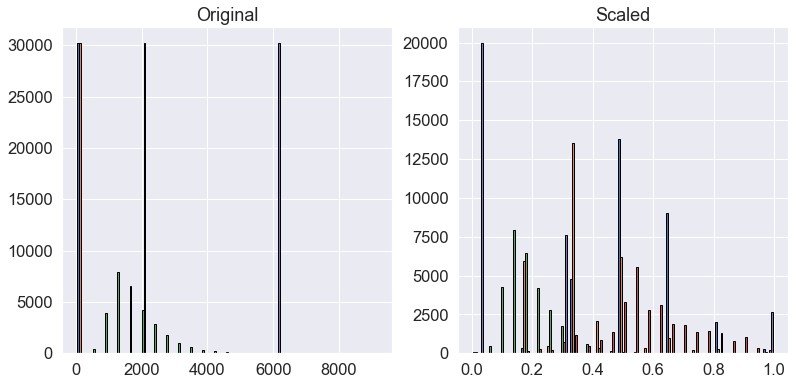

In [24]:
scaler = sklearn.preprocessing.MinMaxScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(X_train)

x_train_scaled = scaler.transform(X_train)
x_validate_scaled = scaler.transform(X_validate)
x_test_scaled = scaler.transform(X_test)

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(x_train_scaled, bins=25, ec='black')
plt.title('Scaled')

### Create and fit a new home_value prediction model

In [25]:
from sklearn.linear_model import LinearRegression
# TEST ON X TRAIN


In [26]:
# creating the model

lm = LinearRegression(normalize = True)
lm.fit(x_train_scaled, y_train.home_value)
y_train['home_value_pred_lm'] = lm.predict(x_train_scaled)

In [27]:
# let's create a dataframe with all four (4) features:
# home_value (dependent variable)
# finished_sq_feet (independent variable)
# predicted avg. baseline home value
# created model predictions

#evaluate: RMSE
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_lm)**(1/2)

# predict validate
y_validate['home_value_pred_lm'] = lm.predict(x_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)



# just use x train

#df = pd.concat([x_train_scaled, y_train], axis = 1)
#lm_df = df.copy().reset_index(drop = True)

#lm_df["baseline"] = baseline_predictions

RMSE for OLS using LinearRegression
Training/In-Sample:  228418.63111826248 
Validation/Out-of-Sample:  230805.24503556459


In [28]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(x_train_scaled, y_train.home_value)

# predict train
y_train['home_value_pred_lars'] = lars.predict(x_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_lars)**(1/2)

# predict validate
y_validate['home_value_pred_lars'] = lars.predict(x_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Lasso + Lars
Training/In-Sample:  228419.11253380615 
Validation/Out-of-Sample:  230801.60687514063


In [29]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(x_train_scaled, y_train.home_value)

# predict train
y_train['home_value_pred_glm'] = glm.predict(x_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_glm)**(1/2)

# predict validate
y_validate['home_value_pred_glm'] = glm.predict(x_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  235731.0170064429 
Validation/Out-of-Sample:  245187.76054937055


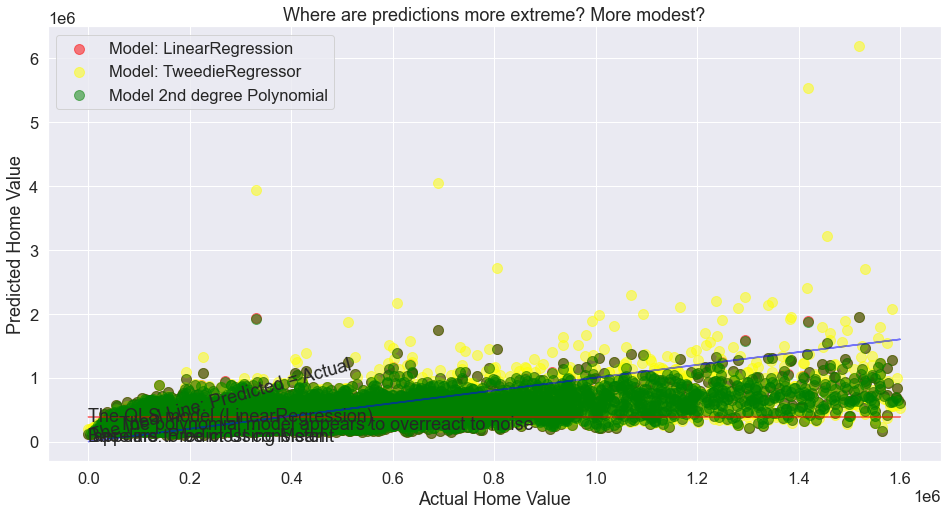

In [30]:
# Evaluate
# Plotted Actual vs. Predicted Values

# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.home_value, y_validate.home_value_pred_mean, alpha=.5, color="red", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.home_value, y_validate.home_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.home_value, y_validate.home_value_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.home_value, y_validate.home_value_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.home_value, y_validate.home_value_pred_lars, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Home Value")
plt.ylabel("Predicted Home Value")
plt.title("Where are predictions more extreme? More modest?")
plt.annotate("The polynomial model appears to overreact to noise", (60000, 200000))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()


### Create markdown with conclusions


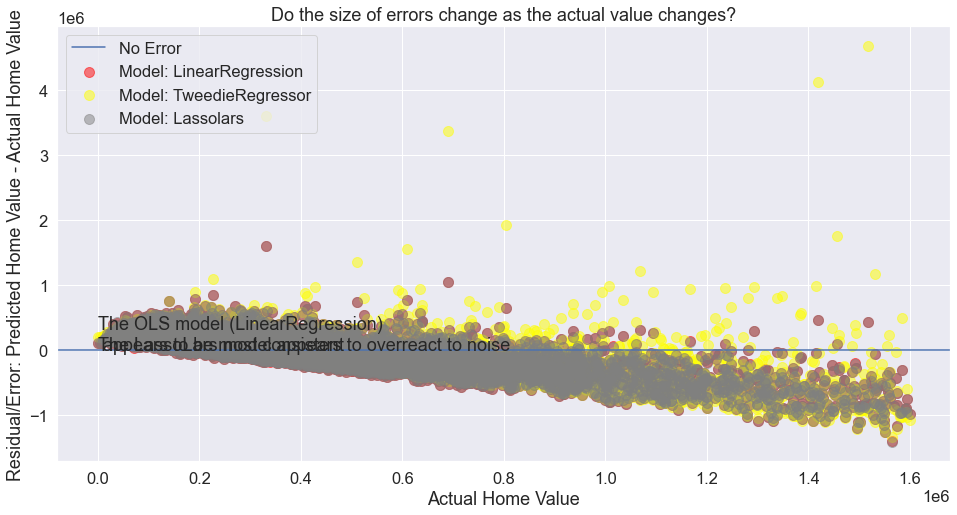

In [31]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.home_value, y_validate.home_value_pred_lm-y_validate.home_value, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.home_value, y_validate.home_value_pred_glm-y_validate.home_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.home_value, y_validate.home_value_pred_lars-y_validate.home_value, 
            alpha=.5, color="gray", s=100, label="Model: Lassolars")
plt.legend()
plt.xlabel("Actual Home Value")
plt.ylabel("Residual/Error: Predicted Home Value - Actual Home Value")
plt.title("Do the size of errors change as the actual value changes?")
plt.annotate("The LassoLars model appears to overreact to noise", (1.2, 4))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (2, 3))
plt.show()



### Model Selection & Out-of-Sample Evaluation

RMSE for OLS using LinearRegression
- Training/In-Sample:  228,418.63
- Validation/Out-of-Sample:  230,805.24

RMSE for Lasso + Lars
- Training/In-Sample:  228,419.11
- Validation/Out-of-Sample:  230,801.60

RMSE for GLM using Tweedie, power=1 & alpha=0
- Training/In-Sample:  235,731.01
- Validation/Out-of-Sample:  245,187.76

In [32]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['home_value_pred_lm'] = lm.predict(x_test_scaled)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.home_value, y_test.home_value_pred_lm)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)


RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  228043.67712189737


### Takeaways:
- I chose Linear Regression because it performed slightly better than the Lasso Lars model.
- My test model ended up outperforming the train and validate datasets.
- Definetly beats the baseline prediction of 385,876.79